<a href="https://colab.research.google.com/github/leonSadowski/sc_Hierarchical_Classifier/blob/main/NN_class_dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np 
import tensorflow as tf 
import tensorflow.keras as keras 
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import networkx as nx

**Create Class for local (NN) classifier**

In [ ]:
class Neural_Network():

  def __init__(self, 
               x_input_data,
               y_input_data,
               len_of_output, #NEU!!!!! ÜBERGEBE LÄNGE DES OUTPUT VEKTORS WEIL Y_INPUT KEIN PANDAS DATAFRAME MEHR IST
               z_transform_input = True,
               list_of_hidden_layer_nodes = [30],
               activation_function = 'relu',
               learning_rate = 0.001,
               momentum = .9,
               loss_function = 'categorical_crossentropy',
               epochs = 50):
    
    self.x_input_data = x_input_data
    self.y_input_data = y_input_data
    self.list_of_layer_nodes = [len(self.x_input_data[0])] + [nodes for nodes in list_of_hidden_layer_nodes] + [len_of_output] #[len(self.y_input_data.cat.categories)] 
    self.activation_function = activation_function 
    self.learning_rate = learning_rate
    self.momentum = momentum
    self.loss_function = loss_function
    self.epochs = epochs
    self.z_transform_input = z_transform_input

    #create model

    self.model = keras.models.Sequential()

    for nodes, layer_idx in zip(self.list_of_layer_nodes, range(0, len(self.list_of_layer_nodes)-1)):

      self.model.add(keras.layers.Dense(
          input_shape = (nodes,),
          units = self.list_of_layer_nodes[layer_idx+1],                            #Ausgabeknotenanzahl == Anzahl Knoten der nächsten Schicht
          kernel_initializer = 'glorot_uniform',                                    #default      
          bias_initializer = 'zeros',                                               #werden die im fit berücksichtigt?
          activation = self.activation_function if layer_idx == 0 else 'softmax'))  #actication als default 'relu', in letzter schicht 'softmax'
        

  def process_input_data(self):

    #z transformation 

    def z_transform_properties(data_arr):
      '''Calculates a z transformation to center properties across cells in data_arr around mean zero'''
      
      mean_vals = np.mean(data_arr, axis=0)
      std_val = np.std(data_arr)

      data_transformed = (data_arr - mean_vals) / std_val

      return data_transformed


    if self.z_transform_input:
      self.x_input_data = z_transform_properties(self.x_input_data)
      
    #converting labels of y_input_data to integers (mapping 'label'->int)

    # ----> erstmal so vereinfacht, dass incoming y_data encoded wird -> ist wegen group_by_labels eh mit strings

    self.label_encoder = LabelEncoder()
    self.y_input_data_int = self.label_encoder.fit_transform(self.y_input_data)

    # if isinstance(self.y_input_data, pd.Series):
    #   #encode categorical labels from pandas Series as integers
    #   self.label_encoder = LabelEncoder()
    #   self.y_input_data_int = self.label_encoder.fit_transform(self.y_input_data.values)

    # elif isinstance(self.y_input_data[0], np.ndarray) and self.y_input_data.dtype == int: #so vereinfachen, dass einfach immer encoded wird. mit neuer 'pipeline' wird eh nur y_input mit strings weitergegeben
    #   self.y_input_data_int = self.y_input_data

    # elif isinstance(self.y_input_data[0], np.ndarray) and self.y_input_data.dtype == str: #y_input kein dataframe mehr, sondern Liste wegen preprocessing!
    #   self.y_input_data_int = self.label_encoder.fit_transform(self.y_input_data)

    # else:

    #   print('Error: Invalid or unknown Data Type for Y Input data')

  

    #split data (TO DO: implement scikit.learn cross_val_score for k-fold cross validation)

    split_data_index = int(2/3 * len(self.x_input_data))

    self.x_training_input = self.x_input_data[ : split_data_index]
    self.y_training_input_int = self.y_input_data_int[ : split_data_index]

    self.x_test_input = self.x_input_data[split_data_index : ]
    self.y_test_input_int = self.y_input_data_int[split_data_index : ]

    #use integer y_input data for OneHot Encoding (int -> e_i element R^(int+1)) needed for model training

    self.y_training_onehot = keras.utils.to_categorical(self.y_training_input_int)
    self.y_test_onehot = keras.utils.to_categorical(self.y_test_input_int)


  def train(self):
    '''Train the NN using the x_training_data input and onehot encoded y_training_onehot'''

    self.optimizer = keras.optimizers.SGD(learning_rate = self.learning_rate, momentum = self.momentum)
    
    self.model.compile(optimizer = self.optimizer, loss = self.loss_function)

    history = self.model.fit(self.x_training_input, self.y_training_onehot,
                        batch_size = 64, epochs = self.epochs, 
                        verbose = 1,
                        validation_split = .1)
    
  def predict(self, input_vec):
    '''Calculate and return label prediction of trained model for an input vector
        input_vec (dtype=int)'''

    pred_vec = np.argmax(self.model.predict(input_vec), axis = -1) #-1?

    return pred_vec


  def validate(self):

    self.y_training_preds = self.predict(self.x_training_input)
    self.y_test_preds = self.predict(self.x_test_input) 

    def calc_acc(pred_vec, known_vec):
      
      if type(pred_vec) == type(known_vec):
        acc = np.sum(pred_vec == known_vec, axis = 0) / len(known_vec)
      else:
        print('self.validate: Error! Comparison of different label encoding!')
      
      return acc
    
    # ---> save in node memory, not in classifier model
    # self.train_acc = calc_acc(self.y_training_preds, self.y_training_input_int) 
    # self.test_acc = calc_acc(self.y_test_preds, self.y_test_input_int)

    train_acc = calc_acc(self.y_training_preds, self.y_training_input_int)
    test_acc = calc_acc(self.y_test_preds, self.y_test_input_int)

    return train_acc, test_acc


  def master_method_NN(self, validate):
    '''method to run all relevant neural network methods, to be called from hierarchical classifier!
    not sure if needed'''
    
    # self.process_input_data()
    # self.train()

    #prediction vector soll in node_memory gespeichert werden!

    pass



    
    
  



In [ ]:
class Node_Memory():

  def __init__(self, x_input_data = None, y_input_data = None, local_classifier = None, local_classifier_params = []):

      #local_classifier argument is the Class of classifier (eg Neural_Network (classifier specific params, input and output needed for every possible classifier))
      #initialize all needed attributes, but assign via HC objects

      self.x_input_data = x_input_data  #processing wird von local classifier übernommen (CAVE bei Verwendung anderer LC (eg SVM), dass preprocessing einheitlich ist)
      self.y_input_data = y_input_data 

      self.y_input_grouped_labels = None  #is generated via Hierarchical classifier, maps all labels to labels of children of THIS node object

      self.apriori_y_input_data_indices = None #save indices of data in y_input vector, that will be used for prediction in order to compute accuracy
      
      #still manual splitting -> adjust to k fold CV in future
      self.training_prediction_vec = None
      self.test_prediction_vec = None

      self.training_acc = None
      self.test_acc = None

      #SEEEEEEEHR UNSCHÖÖÖÖÖÖN, PROBLEM MIT Y_INPUT_GROUPED_BY_LABELS_BEHEBEN!! DANN INITIALISIEREN WIEDER IN KONSTRUKTOR SCHREIBEN
      self.classifier_class = local_classifier #zwischenspeichern der Klasse bis y_input_grouped labels durch HC ausgegeben wurde --> SEHR UNSCHÖN
      self.local_classifier_params = local_classifier_params

  def initialize_local_classifier(self, local_classifier_output_len):
    if self.classifier_class != None:
      self.local_classifier = self.classifier_class(self.x_input_data, self.y_input_grouped_labels, local_classifier_output_len, *self.local_classifier_params)  #use y_input with labels that refer to the child nodes
    else:
      #TO DO: bessere Lösung einfallen lassen
      print('WARNING! No classifier initialized!')

  #---> sollte eher auch von 'Oberklasse' ausgeführt werden
  #Methoden zur Ausführung des local classifiers eines parent nodes
    
  # def run_local_classifier(self):               
  #   self.local_classifier.train()
  
  #----> soll über hierarchical_classifier objekt aufgerufen werden
  # def local_classifier_prediction(self, input_vec): #hier muss noch was passieren, prediction von außen für bestimmte inputs aufrufen
  #   self.local_classifier.predict(input_vec)

In [ ]:
def make_graph_from_edges(d, g, parent_key=''):
    for key in d.keys():
        if parent_key != '':
            g.add_edge(parent_key, key)
        if len(d[key]) == 0:
            pass
        else:
            make_graph_from_edges(d[key], g, parent_key=key)

In [ ]:
def list_subgraph_nodes(g, parent_node):
  list_of_nodes = []
  for node in g.adj[parent_node].keys():
    if len(g.adj[parent_node].keys()) != 0:
      list_of_nodes.append(node)
      list_of_nodes = list_of_nodes + list_subgraph_nodes(g, node)
    else:
      list_of_nodes.append(node)
  return list_of_nodes

In [ ]:
class Hierarchical_Classifier():
  '''Class connects Nodes of Local Classifiers, passes results to children classifiers and forms the final hierarchical classifier''' 

  def __init__(self, dict_of_cell_relations):
    '''Params
        - dict_of_cell_relations: used for initializing network structure of hierarchical classifier'''
    self.dict_of_cell_relations = dict_of_cell_relations


  def make_classifier_graph(self):
    '''Compute Graph from a given dictionary of cell relationships'''
    self.graph = nx.DiGraph()
    make_graph_from_edges(self.dict_of_cell_relations, self.graph)

  def init_node_memory_object(self, node, memory_class_params=[]):
    '''Add memory object to each node; memory object organizes all relevant local classifier params'''
    self.graph.add_node(node, memory=Node_Memory(*memory_class_params)) #lade die relevanten Daten
    if len(memory_class_params) != 0: #auch sehr unschön ---> so ändern, dass konflit mit NN Initialisierung und berechnen von y_input_grouped_labels in node memory nicht auftritt
      self.group_labels_of_subgraph_to_parent_label(node) #schreibe die relevanten (komprimierten) y_input daten durch aufrufen der methode
      self.graph.nodes[node]['memory'].initialize_local_classifier(len(self.graph.adj[node].keys())) #initialisiere den local_classifier (jetzt ist y_input_grouped_labels in node memory gegeben)
                                                                                                      #GEÄNDERT: ÜBERGEBE LÄNGE DES LETZTEN LAYERS DES NN, vorher aus cat.categories geschlossen
                                                                                                      #aber y_input_grouped_labels ist eine Liste
  def run_local_classifier(self, node):
    '''DEV METHOD: use for calling single methods at once to begin with'''
    
    #wo werden dem ersten local classifier die daten übergeben? --> aktuell manuell (s.u. TESTEN)

    #ONLY NEEDED FOR GLOBAL ACCURACY
    #save indices of known labels of daughter nodes in these corresponding nodes (i.e. eg node 'TNK' knows indices of 'TNK' in y_input_data of node 'all' ) 
    next_labels = [label for label in self.graph[node].keys()]
    for label in next_labels:
      self.graph.nodes[label]['memory'].apriori_y_input_data_indices = np.where(np.array(self.graph.nodes[node]['memory'].y_input_data) == label)

    #run needed local classifier methods to train model
    self.graph.nodes[node]['memory'].local_classifier.process_input_data()
    self.graph.nodes[node]['memory'].local_classifier.train()

    #predict trainings and test data (still splitted manually -> k fold cross validation) and save in corresponding node memory
    self.graph.nodes[node]['memory'].training_prediction_vec = self.graph.nodes[node]['memory'].local_classifier.predict(self.graph.nodes[node]['memory'].local_classifier.x_training_input)
    self.graph.nodes[node]['memory'].test_prediction_vec = self.graph.nodes[node]['memory'].local_classifier.predict(self.graph.nodes[node]['memory'].local_classifier.x_test_input)

    #validate model 
    self.graph.nodes[node]['memory'].training_acc, self.graph.nodes[node]['memory'].test_acc =  self.graph.nodes[node]['memory'].local_classifier.validate()


  def run_local_classifier_master(self, node, validate = True):
    '''run master method of local classifier'''
    pass


  #automatisches mapping der feineren labels zu den groberen durch iterieren über die Labels der subgraphen, ausführen über 
  #Hierarchical_Classifier in jedem Knoten --> als y_input_data in node_memory speichern
  #Ziel: mapping aus textzelle automatisieren, dafür: nimm 'Nachbarn' als nächste parentlabel, deren kinder müssen 
  #dann zu Nachbarn gemapped werden

  #benutze den graph, weil hier die ecken bereits klar sind, klarer als in gegebenem dictionary (dort müsste über keys von keys iteriert werden)

  def group_labels_of_subgraph_to_parent_label(self, super_node):
    '''Maps y_input_data labels to parent label (eg map (CD4 T, CD8 T, NK) -> (TNK) for all neighbors of given super_node (eg TNK, B, Others) of Graph g
      Params:
        - super_node: node at which local classifier has to be run
        
      Saves result in y_input_grouped_labels attribute of Node_memory of super_node''' 

    mapping_dict = {node : [child_node for child_node in list_subgraph_nodes(self.graph, node)] for node in self.graph.adj[super_node].keys() }
    mapper = {k:v for v,k in pd.Series(mapping_dict).explode().iteritems()} #write dict such that key and value are interchanged, then map; von StackOverFlow: letze antwort https://stackoverflow.com/questions/32262982/pandas-combining-multiple-categories-into-one
    self.graph.nodes[super_node]['memory'].y_input_grouped_labels = [mapper.get(k) for k in self.graph.nodes[super_node]['memory'].y_input_data]

  def subset_pred_vec(self, node):
    next_labels = [label for label in self.graph[node].keys()]
    for next_label in next_labels:
      #following line decodes integer output of neural network to string labels in order to compare with names of following nodes (again encoded by following local classifier)
      self.graph.nodes[node]['memory'].prediction_vec = self.graph[node]['memory'].local_classifier.label_encoder.inverse_transform(self.graph.nodes[node]['memory'].prediction_vec)
      temp_idx_vec = np.where(np.array(self.graph.nodes[node]['memory'].prediction_vec) == next_label)
      self.graph.nodes[next_label]['memory'].x_input_data = np.array(self.graph.nodes[node]['memory'].x_input_data)[temp_idx_vec]


  def master_method(self):
    '''method to run all relevant methods -> "one-click" initializing of hierarchical classifier (?)'''
    pass



**#######################################################**
**Messy Test bereich**

In [ ]:
# hc.group_labels_of_subgraph_to_parent_label('all')

**Test of Local classifier class**

In [ ]:
!pip install scanpy 


In [ ]:
import scanpy as sc

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
adata = sc.read('drive/MyDrive/single_cell/processed/pbmc3k_level_1_scvi.h5ad')

In [ ]:
adata.obs['leiden']

AAACATACAACCAC-1               CD8 T
AAACATTGAGCTAC-1                   B
AAACATTGATCAGC-1               CD4 T
AAACCGTGCTTCCG-1                  NK
AAACCGTGTATGCG-1    FCGR3A Monocytes
                          ...       
TTTCGAACTCTCAT-1      CD14 Monocytes
TTTCTACTGAGGCA-1                   B
TTTCTACTTCCTCG-1                   B
TTTGCATGAGAGGC-1                   B
TTTGCATGCCTCAC-1               CD4 T
Name: leiden, Length: 2638, dtype: category
Categories (8, object): ['CD4 T', 'CD14 Monocytes', 'B', 'CD8 T', 'NK', 'FCGR3A Monocytes',
                         'Dendritic', 'Megakaryocytes']

In [ ]:
adata.obs['training_level_1']

AAACATACAACCAC-1          TNK
AAACATTGAGCTAC-1            B
AAACATTGATCAGC-1          TNK
AAACCGTGCTTCCG-1          TNK
AAACCGTGTATGCG-1    Myeloisch
                      ...    
TTTCGAACTCTCAT-1    Myeloisch
TTTCTACTGAGGCA-1            B
TTTCTACTTCCTCG-1            B
TTTGCATGAGAGGC-1            B
TTTGCATGCCTCAC-1          TNK
Name: training_level_1, Length: 2638, dtype: category
Categories (4, object): ['B', 'Myeloisch', 'Others', 'TNK']

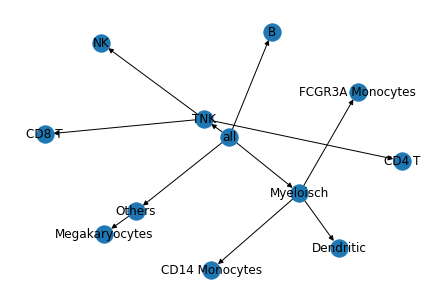

In [ ]:
hc = Hierarchical_Classifier({'all': {'TNK':{'CD4 T':{}, 'CD8 T':{}, 'NK':{}}, 'Myeloisch':{'FCGR3A Monocytes': {}, 'Dendritic':{}, 'CD14 Monocytes':{}}, 'B': {}, 'Others':{'Megakaryocytes':{}}}})
hc.make_classifier_graph()
for node in hc.graph.nodes:
  hc.init_node_memory_object(node)
nx.draw(hc.graph, with_labels=True)

In [ ]:
list_subgraph_nodes(hc.graph, 'all')

['TNK',
 'CD4 T',
 'CD8 T',
 'NK',
 'Myeloisch',
 'FCGR3A Monocytes',
 'Dendritic',
 'CD14 Monocytes',
 'B',
 'Others',
 'Megakaryocytes']

In [ ]:
#save input data for first node and thus first network
# hc.graph.nodes['all']['memory'].x_input_data, hc.graph.nodes['all']['memory'].y_input_data = adata.obsm['X_scVI'], adata.obs['leiden']

In [ ]:
#save input data and initialize first network in first node
hc.init_node_memory_object('all', [adata.obsm['X_scVI'], adata.obs['leiden'], Neural_Network])

In [ ]:
#all set up - run local classifier
hc.run_local_classifier('all')

Epoch 1/50
25/25 [==============================] - 0s 7ms/step - loss: 1.7289 - val_loss: 1.6663
Epoch 2/50
25/25 [==============================] - 0s 2ms/step - loss: 1.4516 - val_loss: 1.3730
Epoch 3/50
25/25 [==============================] - 0s 3ms/step - loss: 1.2277 - val_loss: 1.1725
Epoch 4/50
25/25 [==============================] - 0s 2ms/step - loss: 1.0701 - val_loss: 1.0307
Epoch 5/50
25/25 [==============================] - 0s 3ms/step - loss: 0.9530 - val_loss: 0.9251
Epoch 6/50
25/25 [==============================] - 0s 2ms/step - loss: 0.8612 - val_loss: 0.8414
Epoch 7/50
25/25 [==============================] - 0s 3ms/step - loss: 0.7859 - val_loss: 0.7730
Epoch 8/50
25/25 [==============================] - 0s 2ms/step - loss: 0.7227 - val_loss: 0.7163
Epoch 9/50
25/25 [==============================] - 0s 3ms/step - loss: 0.6691 - val_loss: 0.6681
Epoch 10/50
25/25 [==============================] - 0s 3ms/step - loss: 0.6224 - val_loss: 0.6271
Epoch 11/50
25/25 [

In [ ]:
#print first level classifier model accuracy
print(hc.graph.nodes['all']['memory'].training_acc)

print(hc.graph.nodes['all']['memory'].test_acc)

0.9419795221843004
0.9215909090909091


In [ ]:
# X_input, y_input = adata.obsm['X_scVI'], adata.obs['training_level_1']
# # print(f'y_input: {y_input}' )
# # print(f'\n\n*******************\n {len(y_input.cat.categories)}')
# nn_tnk = Neural_Network(X_input, y_input, epochs = 200)
# nn_tnk.model.summary()
# # nn_tnk.local_classifier_output()
# nn_tnk.process_input_data()
# nn_tnk.train()
# # nn_tnk.predict(nn_tnk.x_training_input)
# nn_tnk.validate()
# print(f'training_acc: {nn_tnk.train_acc:4f}')
# print(f'test_acc: {nn_tnk.test_acc:.4f}')